# Task1: Build a SURROGATE MODEL using RNN 
## Group: Atlas

# Content

1. [Data analysis](#Data-analysis)
2. [The-Forcasting-Model](#The-Forcasting-Model)
    1. [Initialize](#Model-Initialize)
    2. [Model Training](#Model-Training)
3. [Model Evaluation](#Model-Evaluation)

    
4. [Workflow](#Workflow-of-Task1)
    1. [Model Structure](#Description-of-model-structure)
    2. [Model structure adjustment history](#Model-structure-adjustment-history)
    3. [Data processing](#Data-processing)
    4. [Hyperparameter tuning](#Hyperparameter-tuning)




In [1]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from atlaswildfiretool.forecasting.dataloader import CustomDataset
from atlaswildfiretool.forecasting.generate_images import generate
from atlaswildfiretool.forecasting.loss_func import (
    gaussian,
    create_window,
    ssim,
    SSIMLoss,
)
from atlaswildfiretool.forecasting.model import (
    CAE,
    ConvLSTM,
    ConvLSTMCell,
    ImageSequencePredictor,
)
from atlaswildfiretool.forecasting.model_train import train_model
from atlaswildfiretool.forecasting.pre_proccessing import (
    tag_sequences,
    determine_threshold,
    compute_mse,
    detect_changes,
    filter_train_images,
    plot_differences_with_threshold,
    analyze_sequences,
    get_tags,
)

## Data analysis

By analysing the gif of the train data, we find a lot of inactive wildfire which pixels are not expanding. To remove those poor wildfire sequence, we try to identified these wildfire with a automatic detector to find the end-point frame of a wildfire.

In [2]:
# 1.show consecutive frames mse
# 2.explain red line as a cut point of mse
# 3.get the frame number of the cut point
# 4.plot image before and after change point to test the result of the automatic change point detection

In [8]:
train = np.load("Ferguson_fire_train.npy")
test = np.load("Ferguson_fire_test.npy")

Optimal threshold: 0.015510981356349842
Detected change points at indices: [  399  1099  1699  1799  1899  1999  2099  2399  2499  3199  3599  3699
  3799  3899  3999  4099  4199  4299  4399  4499  4599  4699  4799  4899
  4999  5099  5199  5299  5399  5499  5599  5699  5799  5899  5999  6099
  6199  6299  6399  6499  6599  6699  6799  6899  6999  7099  7199  7299
  7399  7499  7599  7699  7799  7899  7999  8099  8199  8299  8399  8499
  8599  8699  8799  8899  8999  9099  9199  9299  9399 10099 10199 10299
 10399 10499 10599 10699 10799 10899 10999 11099 11199 11299 11399 11499
 11599 11699 11799 11899 11999 12099 12199 12299 12399]
Number of change points detected: 93


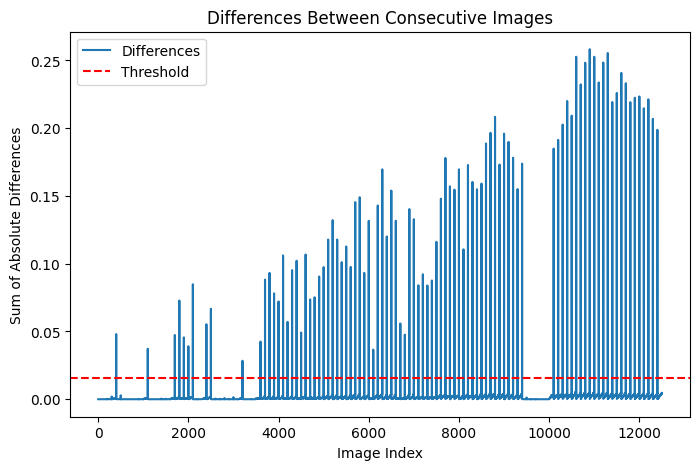

In [9]:
# Plot the differences between consecutive frames with chosen threshold 99.3
# The red line indicates the cut point of 99.3 percentile of the differences
plot_differences_with_threshold(train)

Optimal threshold: 0.015510981356349842


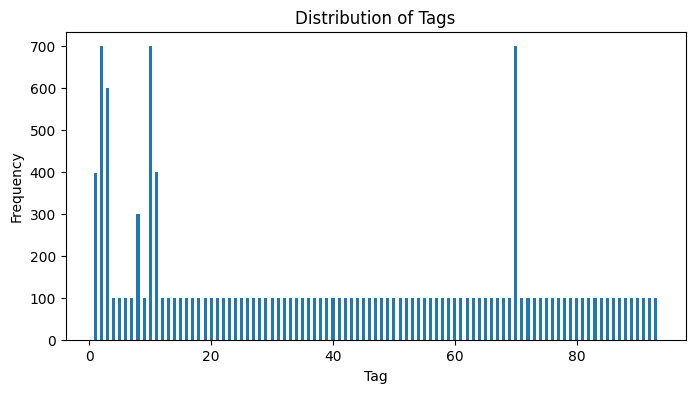

In [10]:
tags = get_tags(train)
analyze_sequences(tags)
# from the below output, we can see that the mode of sequence is 100.

## Truncate the data: maintain the lengths of active wildfire = 100

In [11]:
# Step1: Use the model data for training
# Create DataLoader

filter_train_images(train, save_path="Ferguson_fire_train_filtered.npy")
filter_train_images(test, save_path="Ferguson_fire_test_filtered.npy")
data_file = "Ferguson_fire_train_filtered.npy"
test_file = "Ferguson_fire_test_filtered.npy"

Filtered dataset saved to Ferguson_fire_train_filtered.npy
Filtered dataset saved to Ferguson_fire_test_filtered.npy


## The Forcasting Model


### Model Initialize

In [12]:
# create the model
input_dim = 64
hidden_dim = [128, 64]
kernel_size = (3, 3)
num_layers = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialization
model = ImageSequencePredictor(input_dim, hidden_dim, kernel_size, num_layers)

### Model Training

In [14]:
# Dataset and Dataloader
dataset = CustomDataset(data_file, sequence_length=4, step=9)
split_point = int(0.9 * len(dataset))
train_indices = list(range(0, split_point))
val_indices = list(range(split_point, len(dataset)))
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = CustomDataset(test_file, sequence_length=4, step=9)


batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define loss function and optimiser
criterion = SSIMLoss(window_size=11, size_average=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Training
num_epochs = 1
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

0
Epoch [1/1], \Training Loss: -0.9549, \Test Loss: -0.9360


## Model Evaluation

In [19]:
# Evaluation the performance on the test dataset
# load the exist pth file

# model = ImageSequencePredictor(input_dim, hidden_dim, kernel_size, num_layers)
# model.load_state_dict(torch.load('Task1.pth', map_location=device))

<All keys matched successfully>

Test Mean Squared Error (MSE): 0.0014
Background Mean Squared Error (MSE): 0.0124
Obs Mean Squared Error (MSE): 0.0125


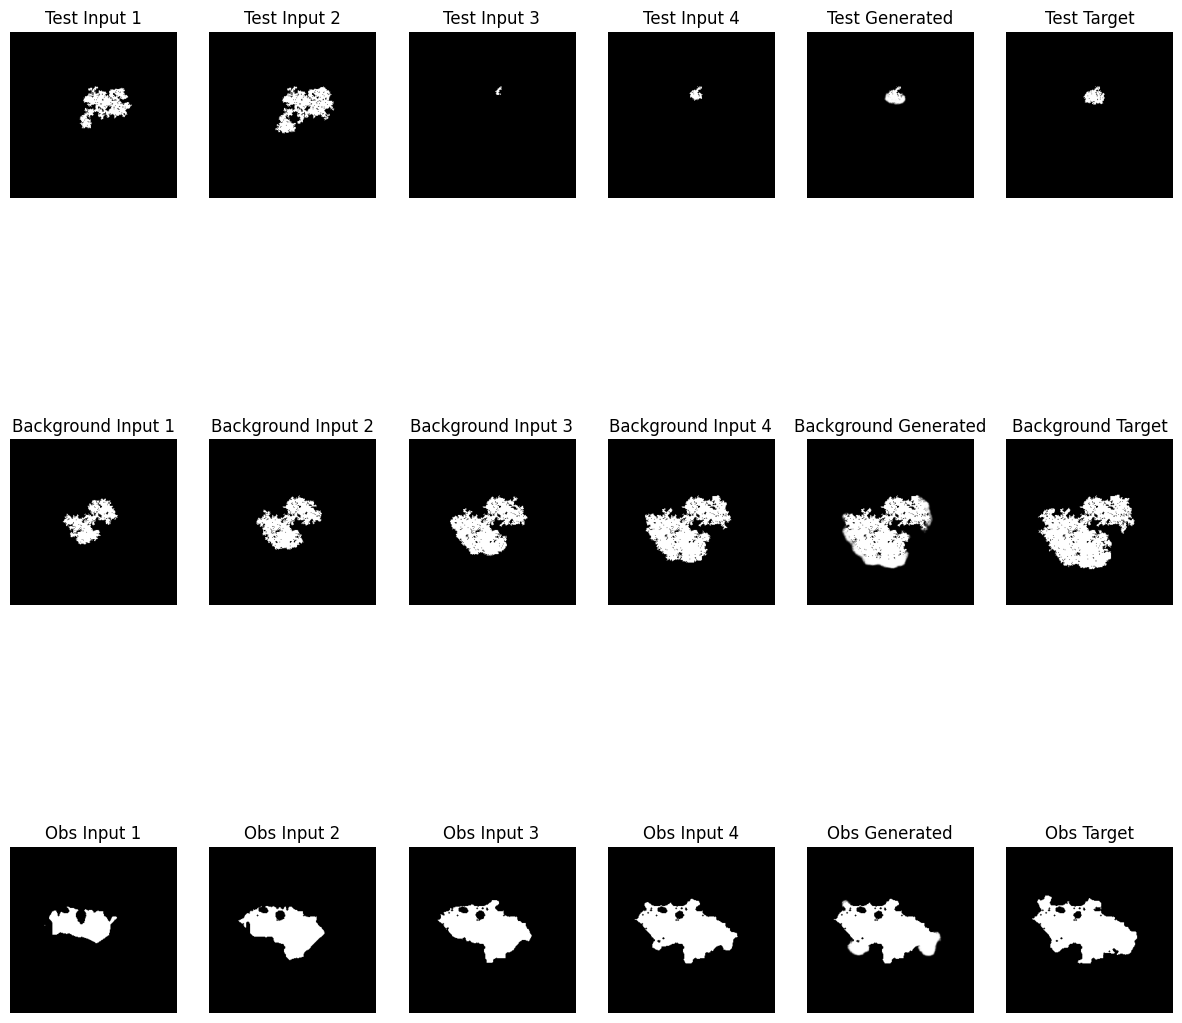

In [20]:
# Testing and Generate
test_data = "Ferguson_fire_test.npy"
back_data = "Ferguson_fire_background.npy"
obs_data = "Ferguson_fire_obs.npy"
num_inputs = 4
start = 589
test_output, background_output, obs_output = generate(
    model, test_data, back_data, obs_data, start, num_inputs, device
)

### Conclusion
During the evaluation of our image sequence prediction model, we obtained the following Mean Squared Error (MSE) results:

On Test data the MSE is 0.0014

On Background data the MSE is 0.0124

On Obs data the MSE is : 0.0125

## Workflow of Task1

## Description of model structure
The ImageSquencePredictor model is designed to predict future frames in a sequence of images by capturing both spatial and temporal dependencies. It consists of three main components: a Convolutional Autoencoder (CAE), a Convolutional LSTM (ConvLSTM), and the overarching Image Sequence Predictor.

`CAE` has two parts: `Encoder and Decoder`.  
Encoder is responsible for encoding the input image into a latent space representation, which is to extract features from the image. Decoder is responsible for decoding the output of ConvLSTM back to the original image space.

`ConvLSTM` is to process time series data. It captures time series and spatial features through two convolutional LSTM unit layers.

`ImageSequencePredictor` combines `CAE` and `ConvLSTM` for sequential image prediction.
First, encode the image at each time step.
Then, the encoded features are fed into ConvLSTM to capture temporal dependencies.
Take the hidden state of the last time step from ConvLSTM.
Finally, the hidden state is decoded through the decoder to generate the predicted image



## Model structure adjustment history
### Model1: CNN + ConvLSTM (2 cells) + Interpolate
The first model structure did not use CAE for compression and decompression, but used a common convolution layer for feature extraction and interpolate for image restoration. In this model structure, image features were not effectively extracted, and interpolate took a long time to restore the image. So I changed to using CAE for image feature extraction (compression) and restoration (decompression).

### Model2: Residual-CAE + ConvLSTM (2 cells)
In the Convolutional Autoencoder (CAE) model, residual structures were introduced into the encoder and decoder. However, this modification did not yield the expected improvement in performance. The likely reason for this outcome is that residual structures are typically beneficial in convolutional neural networks (CNNs) with deeper architectures. Our CAE model, on the other hand, consists of only two convolutional layers, making it relatively shallow.

### Model3: Deep-CAE + ConvLSTM (2 cells)
Introducing deeper Convolutional Autoencoder (CAE) architectures can significantly compress the data, enhancing the efficiency of the model's training time. However, in practice, we observed that deeper CAE models did not yield better results compared to shallower ones. While deeper CAEs can reduce the dimensionality of the data more effectively, leading to faster training times due to smaller representations, they also introduce complexity that can be detrimental to the final performance. 


## Data processing
### Data overview
The time interval between the data in the train and test datasets is 1, while the time interval between the background and obs data we will use to evaluate the model performance is 10. Therefore, during the training process, the interval between the input images passed into the model is 10.
### Filtered .npy file
Although this makes the data distribution passed into the model more reasonable, it also reduces a lot of training data, so after our test, we still keep all the training data.





## Hyperparameter tuning
### learning rate
The choice of a learning rate is critical in training neural networks, as it directly impacts the convergence and stability of the model. After considering various factors, a learning rate of 0.001 was selected for balancing between convergence speed and stability. 0.001 offers a good balance between convergence speed and training stability. Higher learning rates can lead to faster convergence but may cause the model to overshoot minima, resulting in unstable training and divergence. Conversely, lower learning rates ensure stability but can significantly slow down the training process.

### batch size
A batch size of 16 strikes a good balance between utilizing GPU memory efficiently and allowing the model to process a reasonable amount of data at once. This ensures that the model can train effectively without running into memory limitations, especially when using high-resolution images or deeper architectures. Besides, smaller batch sizes, often lead to more stable training. They provide more frequent updates to the model weights, which can help the optimizer navigate the loss landscape more effectively and avoid local minima. This can result in smoother convergence.

### optimizer
The Adam optimizer was chosen for training the model due to its numerous advantages and proven effectiveness in various deep learning applications. It stands for Adaptive Moment Estimation, which means it computes adaptive learning rates for each parameter. This feature allows Adam to adjust the learning rate for each parameter dynamically based on the first and second moments of the gradients, resulting in more efficient and effective training.